# Text-Guided Editing of Images (Using CLIP and StyleGAN)

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/orpatashnik/StyleCLIP.git

import os
os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 778 (delta 119), reused 105 (delta 105), pack-reused 618 (from 1)
Receiving objects: 100% (778/778), 193.81 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Updating files: 100% (246/246), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v1gefb6w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v1gefb6w
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
experiment_type = 'edit' #@param ['edit', 'free_generation']

description = 'angry' #@param {type:"string"}

latent_path = None #@param {type:"string"}

optimization_steps = 40 #@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}


In [3]:
use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type: "number"}

In [4]:
#@title Additional Arguments
args = {
    "description": description,
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results",
    "ir_se50_weights": "model_ir_se50.pth"
}

In [5]:
import numpy as np, glob

# Step 1: Load .npy files (StyleSpace format)
dir_files = sorted(glob.glob('global_directions/npy/ffhq/*.npy'))
assert len(dir_files) > 0, "❌ No .npy files found!"

# Step 2: Load all as-is (StyleSpace directions)
raw = []
for f in dir_files:
    arr = np.load(f)
    if arr.ndim == 1:
        raise ValueError(f"❌ Flattened 1D file {f} is not supported here")
    raw.append(arr)

raw = np.stack(raw)  # Shape: (N, 6048, 512)
print("✅ Loaded shape:", raw.shape)

# Step 3: Flatten each direction to (N, 6048×512)
flat = raw.reshape(raw.shape[0], -1)

# Step 4: Gram–Schmidt orthogonalization
def gram_schmidt(vectors, eps=1e-8):
    Q = []
    for v in vectors:
        w = v.copy()
        for q in Q:
            w -= np.dot(w, q) * q
        n = np.linalg.norm(w)
        if n > eps:
            Q.append(w / n)
    return np.stack(Q)

orth_flat = gram_schmidt(flat)

# Step 5: Reshape back to (N, 6048, 512)
orth = orth_flat.reshape(raw.shape)

# Step 6: Save
print("📐 Final orth shape:", orth.shape)
np.savez("orth_dirs.npz", dirs=orth)
print(f"✅ Saved {orth.shape[0]} orthogonal StyleSpace directions to orth_dirs.npz")

✅ Loaded shape: (1, 6048, 512)
📐 Final orth shape: (1, 6048, 512)
✅ Saved 1 orthogonal StyleSpace directions to orth_dirs.npz


In [9]:
# ------------------------------------------------------------------
#   convert_s_to_wplus.py        ← run ONCE, then reuse the .npz
# ------------------------------------------------------------------
import numpy as np, torch
from models.stylegan2.model import Generator, StyledConv, ToRGB   # repo modules

# 1.  paths --------------------------------------------------------
CKPT   = "stylegan2-ffhq-config-f.pt"   # <- your weight file
S_PATH = "global_directions/npy/ffhq/fs3.npy"               # <- any fs*.npy

s_dir = np.load(S_PATH)                                     # (6048,512)
assert s_dir.shape == (6048, 512), "This .npy is not 6048×512!"

# 2.  build the exact input‑channel list for this checkpoint ------
g = Generator(1024, 512, 8).eval()                          # res, latent‑dim, n_mlp
g_ema.load_state_dict(torch.load(args.ckpt)["g_ema"], strict=False)

in_ch = []
for m in g.synthesis.modules():              # walk the synthesis network
    if isinstance(m, StyledConv):
        in_ch.append(m.conv.weight.shape[1]) # input channels of conv
    elif isinstance(m, ToRGB):
        in_ch.append(m.conv.weight.shape[1]) # ToRGB input channels
assert len(in_ch) == 26 and sum(in_ch) == 6_048, f"split is wrong: {len(in_ch)=}, {sum(in_ch)=}"

# 3.  collapse StyleSpace ⇒ W⁺ ------------------------------------
w_vecs, ptr = [], 0

# first resolution (4×4): conv1, ToRGB
for _ in range(2):
    nch = in_ch.pop(0)
    w_vecs.append(s_dir[ptr : ptr + nch].mean(axis=0))
    ptr += nch

# remaining 8 resolutions: conv1   |  conv2 + ToRGB
while in_ch:
    # conv1
    nch = in_ch.pop(0)
    w_vecs.append(s_dir[ptr : ptr + nch].mean(axis=0))
    ptr += nch
    # conv2 + ToRGB (share one W+ style index)
    nch2 = in_ch.pop(0)
    nch3 = in_ch.pop(0)
    block = np.vstack((s_dir[ptr : ptr + nch2],
                       s_dir[ptr + nch2 : ptr + nch2 + nch3]))
    w_vecs.append(block.mean(axis=0))
    ptr += nch2 + nch3

w_dir = np.stack(w_vecs)                               # (18,512)
np.savez("orth_dirs_wplus.npz", dirs=w_dir)
print("✅  orth_dirs_wplus.npz written:", w_dir.shape,
      "– NaNs:", np.isnan(w_dir).sum())

FileNotFoundError: [Errno 2] No such file or directory: '../pretrained_models/stylegan2-ffhq-config-f.pt'

In [55]:
if use_seed:
  import torch
  torch.manual_seed(seed)
import importlib
import optimization.run_optimization
importlib.reload(optimization.run_optimization)

from optimization.run_optimization import main
from argparse import Namespace
result = main(Namespace(**args))

⚠️ Error loading orth_dirs.npz: The size of tensor a (18) must match the size of tensor b (6048) at non-singleton dimension 1
Loading ResNet ArcFace


loss: 0.8022;: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


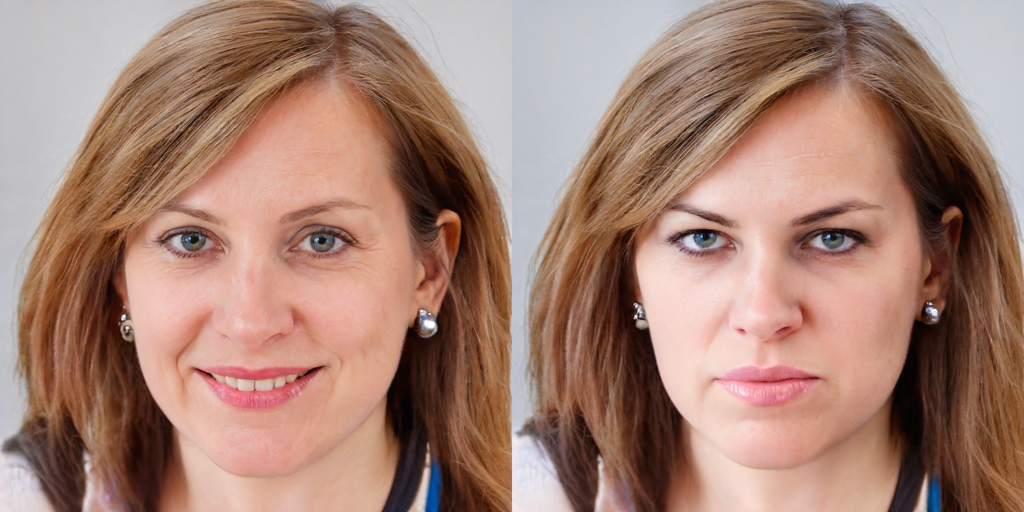

In [56]:
#@title Visualize Result
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, value_range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
#@title Create and Download Video

!ffmpeg -r 15 -i results/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
from google.colab import files
files.download('out.mp4')